# How to create branches for parallel node execution

LangGraph4j lets you run nodes in parallel to speed up your total graph execution.

‼️ Currently there are some overall **limitations** on parallel node implementation execution:

 
* Only the **Fork-Join** model is supported
    
```
          ┌─┐
          │A│      
          └─┘       
           |        
     ┌-----------┐  
     |     |     |  
   ┌──┐  ┌──┐  ┌──┐ 
   │A1│  │A2│  │A3│ 
   └──┘  └──┘  └──┘ 
     |     |     |  
     └-----------┘  
           |        
          ┌─┐       
          │B│       
          └─┘       
```
* Only **one paraller step** is allowed 
```
          ┌─┐
          │A│      
          └─┘       
           |        
     ┌-----------┐  
     |     |     |  
   ┌──┐  ┌──┐  ┌──┐ 
   │A1│  │A2│  │A3│ 
   └──┘  └──┘  └──┘ 
     |     |     |  
   ┌──┐    |     |    
   │A4│ ❌ Not Allowed  
   └──┘    |     |   
     |     |     |  
     └-----------┘  
           |        
          ┌─┐       
          │B│       
          └─┘       
```

* No **Conditional Edges** are allowed
  
Below are some examples showing how to add create branching dataflows.


In [1]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "1.9.1";
var langchain4jbeta = "1.9.1-beta17";
var langgraph4jVersion = "1.7-SNAPSHOT";

In [2]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

In [3]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.slf4j:slf4j-jdk14:2.0.9
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add org.bsc.langgraph4j:langgraph4j-langchain4j:\{langgraph4jVersion}
%dependency /add dev.langchain4j:langchain4j:\{langchain4jVersion}
%dependency /add dev.langchain4j:langchain4j-open-ai:\{langchain4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.8

%dependency /resolve

Repository local url: file:///Users/bsorrentino/.m2/repository/ added.
Adding dependency org.slf4j:slf4j-jdk14:2.0.9
Adding dependency org.bsc.langgraph4j:langgraph4j-core:1.7-SNAPSHOT
Adding dependency org.bsc.langgraph4j:langgraph4j-langchain4j:1.7-SNAPSHOT
Adding dependency dev.langchain4j:langchain4j:1.9.1
Adding dependency dev.langchain4j:langchain4j-open-ai:1.9.1
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.8
Solving dependencies
Resolved artifacts count: 17
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-jdk14/2.0.9/slf4j-jdk14-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-api/2.0.9/slf4j-api-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j/langgraph4j-core/1.7-SNAPSHOT/langgraph4j-core-1.7-SNAPSHOT.jar
Add to classpath: /Users/bsorrentino/Library/Jupyte

In [4]:
try( var file = new java.io.FileInputStream("./logging.properties")) {
    java.util.logging.LogManager.getLogManager().readConfiguration( file );
}

In [5]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;

java.awt.Image plantUML2PNG( String code ) throws IOException { 
    var reader = new SourceStringReader(code);

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        return javax.imageio.ImageIO.read( imageInStream );

    }
}

## Define Graph with parallel branch

In [6]:
import org.bsc.langgraph4j.prebuilt.MessagesStateGraph;
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;

AsyncNodeAction<MessagesState<String>> makeNode( String message ) {
    return node_async(state -> Map.of( "messages", message ) );
}

var workflow = new MessagesStateGraph<String>()
                .addNode("A", makeNode("A"))
                .addNode("A1", makeNode("A1"))
                .addNode("A2", makeNode("A2"))
                .addNode("A3", makeNode("A3"))
                .addNode("B", makeNode("B"))
                .addNode("C", makeNode("C"))
                .addEdge("A", "A1")
                .addEdge("A", "A2")
                .addEdge("A", "A3")
                .addEdge("A1", "B")
                .addEdge("A2", "B")
                .addEdge("A3", "B")
                .addEdge("B", "C")
                .addEdge(START, "A")
                .addEdge("C", END)                   
                .compile();


## Print graph representation

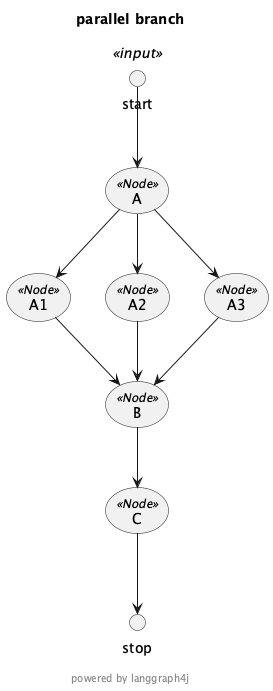

aafcc16e-9725-4bd7-9392-16bd4518bb33

In [7]:
import org.bsc.langgraph4j.GraphRepresentation;

var representation = workflow.getGraph( GraphRepresentation.Type.PLANTUML, "parallel branch",false );

display( plantUML2PNG( representation.getContent() ) )

In [8]:
for( var step : workflow.stream( Map.of() ) ) {
    System.out.println( step );
}

START 


NodeOutput{node=__START__, state={
	messages=[]
	}}
NodeOutput{node=A, state={
	messages=[
	A
	]
	}}
NodeOutput{node=__PARALLEL__(A), state={
	messages=[
	A
	A1
	A2
	A3
	]
	}}
NodeOutput{node=B, state={
	messages=[
	A
	A1
	A2
	A3
	B
	]
	}}
NodeOutput{node=C, state={
	messages=[
	A
	A1
	A2
	A3
	B
	C
	]
	}}
NodeOutput{node=__END__, state={
	messages=[
	A
	A1
	A2
	A3
	B
	C
	]
	}}


In [9]:
import org.bsc.langgraph4j.prebuilt.MessagesStateGraph;
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import org.bsc.langgraph4j.utils.EdgeMappings;

import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.action.AsyncEdgeAction.edge_async;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;


AsyncNodeAction<MessagesState<String>> makeNode( String message ) {
    return node_async(state -> Map.of( "messages", message ) );
}

var workflow = new MessagesStateGraph<String>()
                .addNode("A", makeNode("A"))
                .addNode("A1", makeNode("A1"))
                .addNode("A2", makeNode("A2"))
                .addNode("A3", makeNode("A3"))
                .addNode("B", makeNode("B"))
                .addNode("C", makeNode("C"))
                .addEdge("A", "A1")
                .addEdge("A", "A2")
                .addEdge("A", "A3")
                .addEdge("A1", "B")
                .addEdge("A2", "B")
                .addEdge("A3", "B")
                // .addEdge("B", "C")
                .addConditionalEdges( "B", 
                    edge_async( state -> 
                        state.lastMinus(1) 
                            .filter( m -> Objects.equals(m,"A3"))
                            .map( m -> "continue" )
                            .orElse("back") ), 
                    EdgeMappings.builder()
                        .to( "A1", "back" )
                        .to( "C" , "continue")
                        .build()
                 )
                .addEdge(START, "A")
                .addEdge("C", END)                   
                .compile();


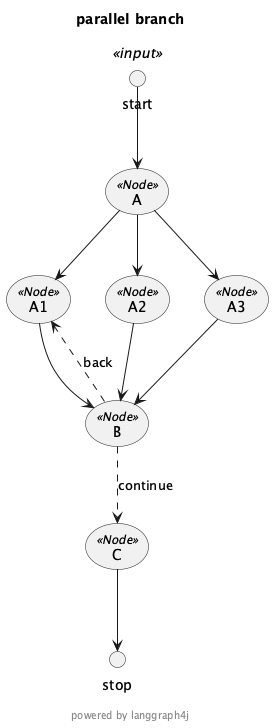

d1e0f9a9-e801-40db-8d4b-257dd7325f78

In [10]:
import org.bsc.langgraph4j.GraphRepresentation;

var representation = workflow.getGraph( GraphRepresentation.Type.PLANTUML, "parallel branch",false );

display( plantUML2PNG( representation.getContent() ) )

In [11]:
for( var step : workflow.stream( Map.of() ) ) {
    System.out.println( step );
}

START 


NodeOutput{node=__START__, state={
	messages=[]
	}}
NodeOutput{node=A, state={
	messages=[
	A
	]
	}}
NodeOutput{node=__PARALLEL__(A), state={
	messages=[
	A
	A1
	A2
	A3
	]
	}}
NodeOutput{node=B, state={
	messages=[
	A
	A1
	A2
	A3
	B
	]
	}}
NodeOutput{node=C, state={
	messages=[
	A
	A1
	A2
	A3
	B
	C
	]
	}}
NodeOutput{node=__END__, state={
	messages=[
	A
	A1
	A2
	A3
	B
	C
	]
	}}


## Use compiled sub graph as parallel node

This example answer to issue **Will plan support multiple target on parallel node?** [#104](https://github.com/bsorrentino/langgraph4j/issues/104) 

In [12]:
import org.bsc.langgraph4j.prebuilt.MessagesStateGraph;
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.action.AsyncEdgeAction.edge_async;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;

AsyncNodeAction<MessagesState<String>> makeNode( String message ) {
    return node_async(state -> Map.of( "messages", message ) );
}

var subgraphA3 = new MessagesStateGraph<String>()
                .addNode("A3.1", makeNode("A3.1"))
                .addNode("A3.2", makeNode("A3.2"))
                .addEdge(START, "A3.1")
                .addEdge( "A3.1", "A3.2")
                .addEdge("A3.2", END)   
                .compile(); 
var subgraphA1 = new MessagesStateGraph<String>()
                .addNode("A1.1", makeNode("A1.1"))
                .addNode("A1.2", makeNode("A1.2"))
                .addEdge(START, "A1.1")
                .addEdge( "A1.1", "A1.2")
                .addEdge("A1.2", END)   
                .compile(); 

var workflow = new MessagesStateGraph<String>()
                .addNode("A", makeNode("A"))
                .addNode("A1", subgraphA1)
                .addNode("A2", makeNode("A2"))
                .addNode("A3", subgraphA3)
                .addNode("B", makeNode("B"))
                .addEdge("A", "A1")
                .addEdge("A", "A2")
                .addEdge("A", "A3")
                .addEdge("A1", "B")
                .addEdge("A2", "B")
                .addEdge("A3", "B")
                .addEdge(START, "A")
                .addEdge("B", END)                   
                .compile();


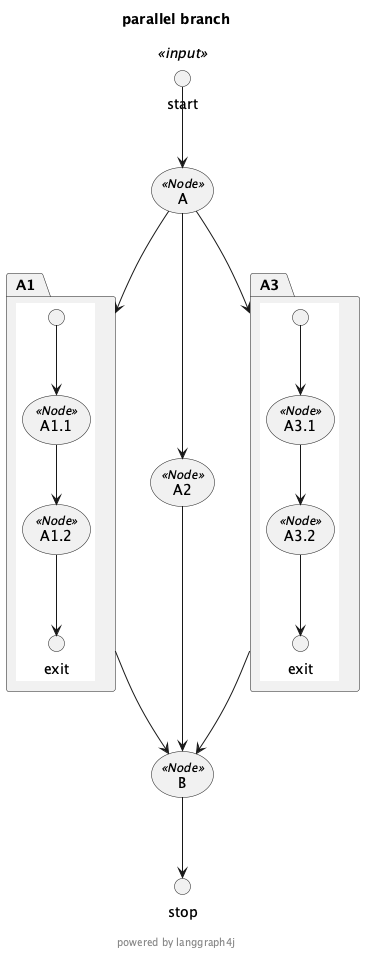

dfdcdf7b-7128-4b35-80a3-522e56de9f47

In [13]:
import org.bsc.langgraph4j.GraphRepresentation;

var representation = workflow.getGraph( GraphRepresentation.Type.PLANTUML, "parallel branch",false );

display( plantUML2PNG( representation.getContent() ) )

In [14]:
// workflow.getGraph( GraphRepresentation.Type.MERMAID, "parallel branch",false ).content();

In [15]:
for( var step : workflow.stream( Map.of() ) ) {
    System.out.println( step );
}

START 


NodeOutput{node=__START__, state={
	messages=[]
	}}


START 
START 


NodeOutput{node=A, state={
	messages=[
	A
	]
	}}
NodeOutput{node=__PARALLEL__(A), state={
	messages=[
	A
	A1.1
	A1.2
	A2
	A3.1
	A3.2
	]
	}}
NodeOutput{node=B, state={
	messages=[
	A
	A1.1
	A1.2
	A2
	A3.1
	A3.2
	B
	]
	}}
NodeOutput{node=__END__, state={
	messages=[
	A
	A1.1
	A1.2
	A2
	A3.1
	A3.2
	B
	]
	}}


In [16]:
import org.bsc.langgraph4j.prebuilt.MessagesStateGraph;
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.action.AsyncEdgeAction.edge_async;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;

AsyncNodeAction<MessagesState<String>> makeNode( String message ) {
    return node_async(state -> Map.of( "messages", message ) );
}

var subgraphA3 = new MessagesStateGraph<String>()
                .addNode("A3.1", makeNode("A3.1"))
                .addNode("A3.2", makeNode("A3.2"))
                .addEdge(START, "A3.1")
                .addEdge( "A3.1", "A3.2")
                .addEdge("A3.2", END)   
                .compile(); 

var subgraphA2 = new MessagesStateGraph<String>()
                .addNode("A2.1", makeNode("A2.1"))
                .addNode("A2.2", makeNode("A2.2"))
                .addEdge(START, "A2.1")
                .addEdge( "A2.1", "A2.2")
                .addEdge("A2.2", END)   
                .compile(); 

var subgraphA1 = new MessagesStateGraph<String>()
                .addNode("A1.1", makeNode("A1.1"))
                .addNode("A1.2", makeNode("A1.2"))
                .addEdge(START, "A1.1")
                .addEdge( "A1.1", "A1.2")
                .addEdge("A1.2", END)   
                .compile(); 

var workflow = new MessagesStateGraph<String>()
                .addNode("A", makeNode("A"))
                .addNode("A1", subgraphA1)
                .addNode("A2", subgraphA2)
                .addNode("A3", subgraphA3)
                .addNode("B", makeNode("B"))
                .addEdge("A", "A1")
                .addEdge("A", "A2")
                .addEdge("A", "A3")
                .addEdge("A1", "B")
                .addEdge("A2", "B")
                .addEdge("A3", "B")
                .addEdge(START, "A")
                .addEdge("B", END)                   
                .compile();


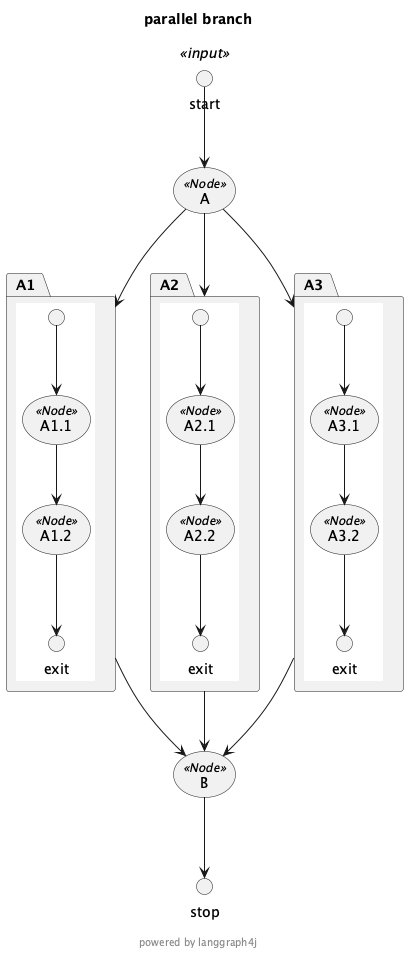

288ddb21-edb9-461d-b418-d4ccdba8fa6b

In [17]:
import org.bsc.langgraph4j.GraphRepresentation;

var representation = workflow.getGraph( GraphRepresentation.Type.PLANTUML, "parallel branch",false );

display( plantUML2PNG( representation.getContent() ) )

In [18]:
for( var step : workflow.stream( Map.of() ) ) {
    System.out.println( step );
}

START 


NodeOutput{node=__START__, state={
	messages=[]
	}}


START 
START 
START 


NodeOutput{node=A, state={
	messages=[
	A
	]
	}}
NodeOutput{node=__PARALLEL__(A), state={
	messages=[
	A
	A1.1
	A1.2
	A2.1
	A2.2
	A3.1
	A3.2
	]
	}}
NodeOutput{node=B, state={
	messages=[
	A
	A1.1
	A1.2
	A2.1
	A2.2
	A3.1
	A3.2
	B
	]
	}}
NodeOutput{node=__END__, state={
	messages=[
	A
	A1.1
	A1.2
	A2.1
	A2.2
	A3.1
	A3.2
	B
	]
	}}
